 ### 02: Attention Pattern Analysis

- Analyzes how GPT-Neo-125M's 144 attention heads (12 layers × 12 heads) route information
- Identifies specialized head types: previous-token trackers, first-token anchors, focused vs. broad
- Shows attention evolves across layers: scattered → sequential → global

In [1]:
# Importing necessary libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import pandas as pd
# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

d:\MambaForge-Mini\envs\project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading the same model
model_name = "EleutherAI/gpt-neo-125M"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_attentions=True,
    output_hidden_states=True,
).to(device)
config = model.config
print(f"Model loaded: {config.num_layers} layers, {config.num_heads} heads per layer")

The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading weights: 100%|██████████| 160/160 [00:00<00:00, 412.18it/s, Materializing param=transformer.wte.weight]                         
GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded: 12 layers, 12 heads per layer


1. Generating text while tracking attention

In [4]:
# Prompt to analyze attention patterns
prompt = "The Eiffel Tower is located in Paris, France. It is a famous tourist site."
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_length = inputs['input_ids'].shape[1]
print(f"Prompt: '{prompt}'")
print(f"Input tokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")
print(f"Number of input tokens: {input_length}")

Prompt: 'The Eiffel Tower is located in Paris, France. It is a famous tourist site.'
Input tokens: ['The', 'ĠE', 'iff', 'el', 'ĠTower', 'Ġis', 'Ġlocated', 'Ġin', 'ĠParis', ',', 'ĠFrance', '.', 'ĠIt', 'Ġis', 'Ġa', 'Ġfamous', 'Ġtourist', 'Ġsite', '.']
Number of input tokens: 19


In [5]:
# Generating with attention tracking
with torch.no_grad():
    output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=False,
    repetition_penalty=10.0,
    return_dict_in_generate=True,
    output_attentions=True,
    output_hidden_states=True,
)
generated_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
all_tokens = tokenizer.convert_ids_to_tokens(output.sequences[0])
print(f"\nGenerated text:\n{generated_text}")
print(f"\nAll tokens: {all_tokens}")
print(f"Total tokens: {len(all_tokens)}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated text:
The Eiffel Tower is located in Paris, France. It is a famous tourist site. The Eiffel tower was built by the French architect Louis-Philippe de Beaumont in 1871 and named after him (the first person to be born there).
It has been used

All tokens: ['The', 'ĠE', 'iff', 'el', 'ĠTower', 'Ġis', 'Ġlocated', 'Ġin', 'ĠParis', ',', 'ĠFrance', '.', 'ĠIt', 'Ġis', 'Ġa', 'Ġfamous', 'Ġtourist', 'Ġsite', '.', 'ĠThe', 'ĠE', 'iff', 'el', 'Ġtower', 'Ġwas', 'Ġbuilt', 'Ġby', 'Ġthe', 'ĠFrench', 'Ġarchitect', 'ĠLouis', '-', 'Philipp', 'e', 'Ġde', 'ĠBe', 'aum', 'ont', 'Ġin', 'Ġ18', '71', 'Ġand', 'Ġnamed', 'Ġafter', 'Ġhim', 'Ġ(', 'the', 'Ġfirst', 'Ġperson', 'Ġto', 'Ġbe', 'Ġborn', 'Ġthere', ').', 'Ċ', 'It', 'Ġhas', 'Ġbeen', 'Ġused']
Total tokens: 59


- As the repetition penalty is set the model produces diverse text without getting stuck in loops.
- The content is factually incorrect (the Eiffel Tower was built by Gustave Eiffel in 1889, not Louis-Philippe de Beaumont in 1871), showing that while the model can generate fluent text, it doesn't reliably produce accurate information

2. Visualizing attention patterns

In [6]:
def plot_attention_heatmap(
    attention_weights: torch.Tensor,
    tokens: List[str],
    layer: int,
    head: int,
    title: str = None) -> None:
    """
    Plotting attention heatmap for a specific layer and head.
    Args:
        attention_weights: Attention tensor of shape (batch, heads, seq_len, seq_len)
        tokens: List of token strings
        layer: Layer index
        head: Head index
        title: Custom title for the plot
    Returns:
        None
    """
    # Extracting attention for specific head
    attn = attention_weights[0, head].cpu().numpy()
    # Plotting attention
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        attn,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='viridis',
        cbar_kws={'label': 'Attention Weight'},
        vmin=0,
        vmax=1
    )
    plot_title = title or f"Layer {layer}, Head {head}"
    plt.title(plot_title, fontsize=14, pad=20)
    plt.xlabel('Key Tokens', fontsize=12)
    plt.ylabel('Query Tokens', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [7]:
# Extracting attention from first generation step for analysis
first_step_attentions = output.attentions[0]

3. Identifying attention head types

In [8]:
def classify_attention_head(
    attention_weights: torch.Tensor,
    threshold: float = 0.5) -> Dict[str, float]:
    """
    Classifying attention head based on its patterns
    Args:
        attention_weights: Attention tensor of shape (seq_len, seq_len)
        threshold: Threshold for determining strong attention.
    Returns:
        Dictionary with scores for different head types
    """
    attn = attention_weights.cpu().numpy()
    seq_len = attn.shape[0]
    # Tracking previous token score: average attention to position i-1 from position i
    prev_token_score = 0
    if seq_len > 1:
        prev_diag = np.array([attn[i, i-1] for i in range(1, seq_len)])
        prev_token_score = np.mean(prev_diag)
    # First token score: average attention to first token
    first_token_score = np.mean(attn[:, 0])
    eps = 1e-10
    entropy = -np.sum(attn * np.log(attn + eps), axis=1)
    avg_entropy = np.mean(entropy)
    max_entropy = np.log(seq_len)
    normalized_entropy = avg_entropy / max_entropy if max_entropy > 0 else 0
    attention_dict={
        'prev_token_score': prev_token_score,
        'first_token_score': first_token_score,
        'entropy': avg_entropy,
        'normalized_entropy': normalized_entropy,
        'is_focused': normalized_entropy < 0.3,
        'is_broad': normalized_entropy > 0.7,
    }
    return attention_dict

In [9]:
head_classifications = []
for layer_idx in range(config.num_layers):
    layer_attns = first_step_attentions[layer_idx][0]
    for head_idx in range(config.num_heads):
        head_attn = layer_attns[head_idx]
        classification = classify_attention_head(head_attn)
        classification['layer'] = layer_idx
        classification['head'] = head_idx
        head_classifications.append(classification)

In [10]:
df_heads=pd.DataFrame(head_classifications)

In [11]:
#Previous token heads:How much each position attends to the token immediately before it (diagonal pattern)
prev_token_heads = df_heads.nlargest(5, 'prev_token_score')[['layer', 'head', 'prev_token_score']]
print("Previous token heads")
prev_token_heads

Previous token heads


,layer,head,prev_token_score
68,5,8,0.999602
57,4,9,0.940641
60,5,0,0.839966
85,7,1,0.534772
24,2,0,0.477692


This table identifies attention heads that specialize in looking at previous tokens.
- Layer 5 Head 8 is almost perfect with 99.96% retention.
- Early layers like Layer 2 Head 0 show weaker specialization (48%).
- Layer 7 shows moderate focus  (53%) indicating that the model builds local sequential dependencies strongly in the middle of network before collating the information more broadly in final layers.

In [12]:
#First token heads:How much all positions attend to the first token (vertical column pattern)
first_token_heads = df_heads.nlargest(5, 'first_token_score')[['layer', 'head', 'first_token_score']]
print("First token heads")
first_token_heads

First token heads


,layer,head,first_token_score
104,8,8,0.987314
73,6,1,0.985639
107,8,11,0.975795
96,8,0,0.974090
97,8,1,0.971421


- Layer 8 dominates first-token attention it has 4 out of 5 top first-token heads (Heads 8, 11, 0, and 1 all with ~97-98% attention to the first token).
- this suggests that later layers use the first token as a "summary anchor" or aggregation point to collect global sentence-level information, which contrasts with middle layers that focus on local sequential dependencies.

In [13]:
#Most focused token heads:Attention spread (0 = focused, 1 = uniform across all tokens)
focused_heads = df_heads.nsmallest(5, 'normalized_entropy')[['layer', 'head', 'normalized_entropy']]
print("Most focused token heads")
focused_heads

Most focused token heads


,layer,head,normalized_entropy
68,5,8,0.000900
136,11,4,0.010133
76,6,4,0.011842
5,0,5,0.017537
2,0,2,0.020173


 - Layer 5 Head 8 (entropy 0.0009) is extremely focused this is the same head we saw as the top previous-token head
 - Focused heads cluster in early-to-middle layers (0-6), laser-focusing on 1-2 specific tokens for precise pattern detection.

In [14]:
#Most broad token heads
broad_heads = df_heads.nlargest(5, 'normalized_entropy')[['layer', 'head', 'normalized_entropy']]
print("Most broad token heads")
broad_heads

Most broad token heads


,layer,head,normalized_entropy
18,1,6,0.674903
12,1,0,0.626268
22,1,10,0.610562
91,7,7,0.596246
26,2,2,0.578365


- Layer 1 dominates with 3 of the 5 broadest heads (entropy ~0.61-0.67), spreading attention widely across many tokens.
- This shows early layers gather diverse contextual information broadly, middle layers specialize and focus sharply, and later layers (like Layer 8) use focused first-token attention for global aggregation revealing a clear computational pipeline through the network.

Visualizing Previous Token Head:


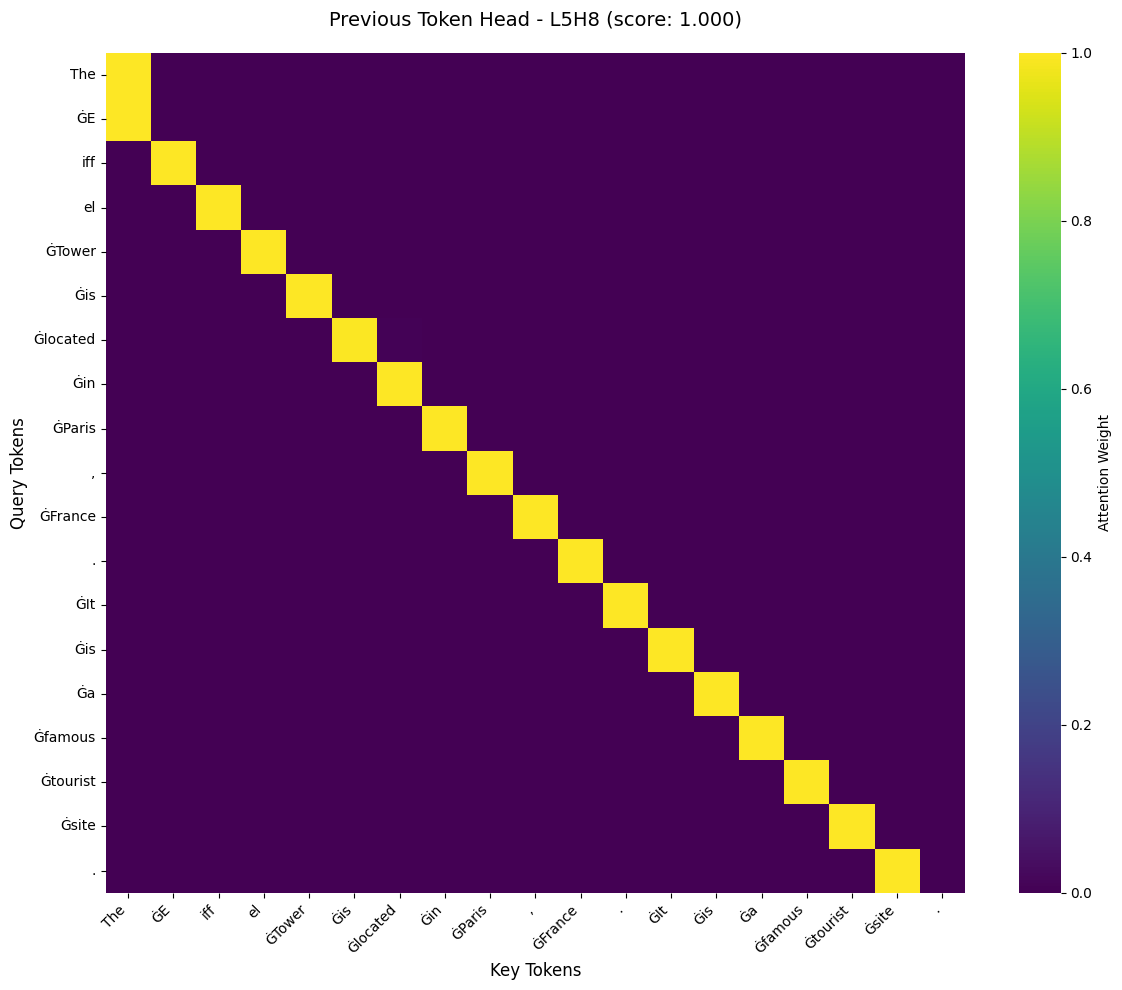


Visualizing First Token Head:


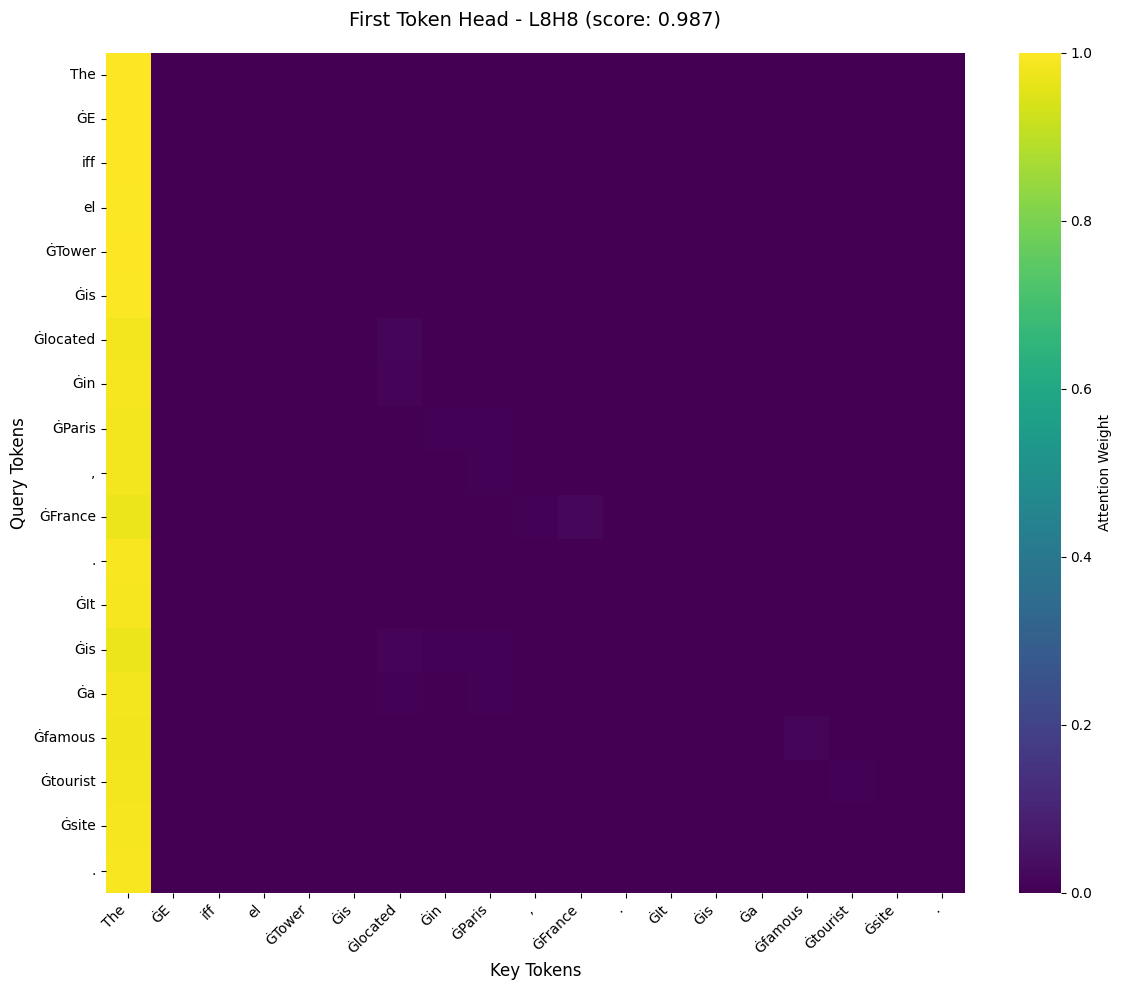


Visualizing Most Focused Head:


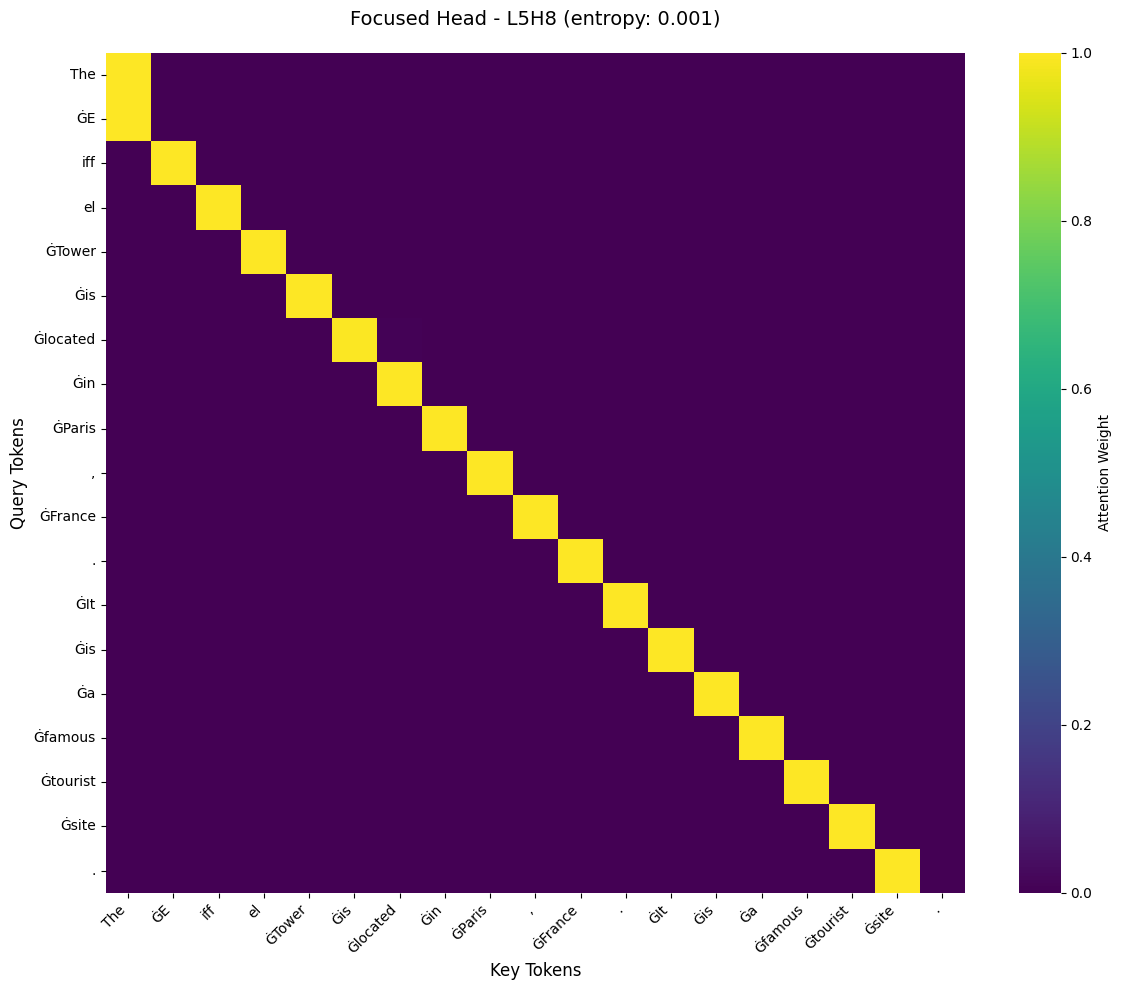

In [15]:
print("Visualizing Previous Token Head:")
top_prev = prev_token_heads.iloc[0]
plot_attention_heatmap(
    first_step_attentions[int(top_prev['layer'])],
    all_tokens[:input_length],
    int(top_prev['layer']),
    int(top_prev['head']),
    f"Previous Token Head - L{int(top_prev['layer'])}H{int(top_prev['head'])} (score: {top_prev['prev_token_score']:.3f})"
)
print("\nVisualizing First Token Head:")
top_first = first_token_heads.iloc[0]
plot_attention_heatmap(
    first_step_attentions[int(top_first['layer'])],
    all_tokens[:input_length],
    int(top_first['layer']),
    int(top_first['head']),
    f"First Token Head - L{int(top_first['layer'])}H{int(top_first['head'])} (score: {top_first['first_token_score']:.3f})"
)
print("\nVisualizing Most Focused Head:")
top_focused = focused_heads.iloc[0]
plot_attention_heatmap(
    first_step_attentions[int(top_focused['layer'])],
    all_tokens[:input_length],
    int(top_focused['layer']),
    int(top_focused['head']),
    f"Focused Head - L{int(top_focused['layer'])}H{int(top_focused['head'])} (entropy: {top_focused['normalized_entropy']:.3f})"
)

- Previous Token Head (L5H8):
It has perfect diagonal pattern indicating each token attends exclusively to its immediate predecessor with neat 100% focus as a pure sequential dependency tracker.
- First Token Head(L8H8):
Every query token highlights the first column ("The") showing attention focused on start as an anchor point.
- Focused Head(L5H8): Its extreme focus comes from putting all attention on exactly one token (predecessor) making it most distinct head in network

4. Attention Patterns Across Layers

C:\Users\Dell\AppData\Local\Temp\ipykernel_21140\1714196337.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


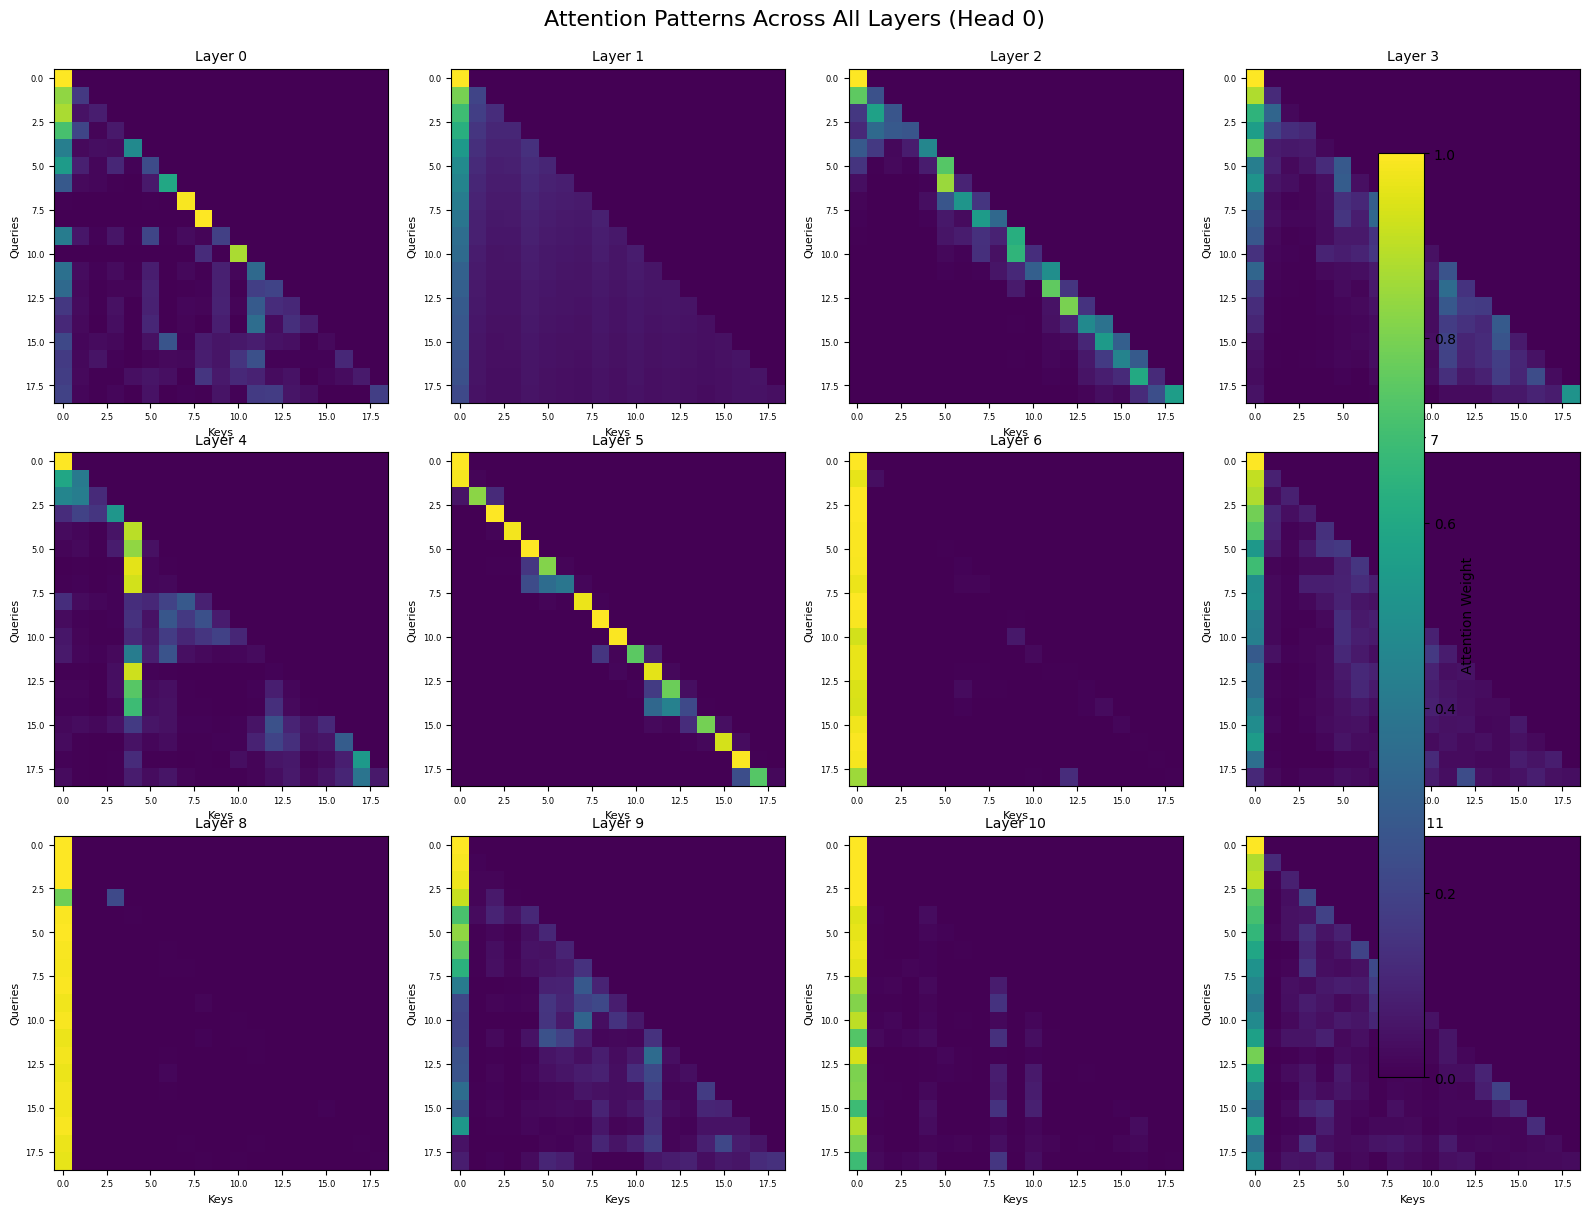

In [16]:
# Visualizing how attention patterns change across layers
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Attention Patterns Across All Layers (Head 0)', fontsize=16, y=1.00)
for layer_idx in range(config.num_layers):
    row = layer_idx // 4
    col = layer_idx % 4
    attn = first_step_attentions[layer_idx][0, 0].cpu().numpy()
    im = axes[row, col].imshow(attn, cmap='viridis', vmin=0, vmax=1)
    axes[row, col].set_title(f'Layer {layer_idx}', fontsize=10)
    axes[row, col].set_xlabel('Keys', fontsize=8)
    axes[row, col].set_ylabel('Queries', fontsize=8)
    axes[row, col].tick_params(labelsize=6)
fig.colorbar(im, ax=axes, label='Attention Weight', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

Layer 0 is scattered then Layers 2-5 develop strong diagonal pattern (previous token), layer 8 shows dominant first column attention and later layers become more distributed.

**Revealing progession from local->sequential->global attention**

5. Average attention by layer

In [17]:
# Computing average attention statistics per layer
layer_stats = []
for layer_idx in range(config.num_layers):
    layer_attns = first_step_attentions[layer_idx][0]
    # Average across heads
    avg_attn = layer_attns.mean(dim=0).cpu().numpy()
    prev_token_attn = np.mean([avg_attn[i, i-1] for i in range(1, avg_attn.shape[0])])
    first_token_attn = np.mean(avg_attn[:, 0])
    # Computing entropy
    eps = 1e-10
    entropy = -np.sum(avg_attn * np.log(avg_attn + eps), axis=1)
    avg_entropy = np.mean(entropy)
    max_entropy = np.log(avg_attn.shape[1])
    normalized_entropy = avg_entropy / max_entropy
    layer_stats.append({
        'layer': layer_idx,
        'prev_token_attn': prev_token_attn,
        'first_token_attn': first_token_attn,
        'normalized_entropy': normalized_entropy,
    })

df_layers = pd.DataFrame(layer_stats)

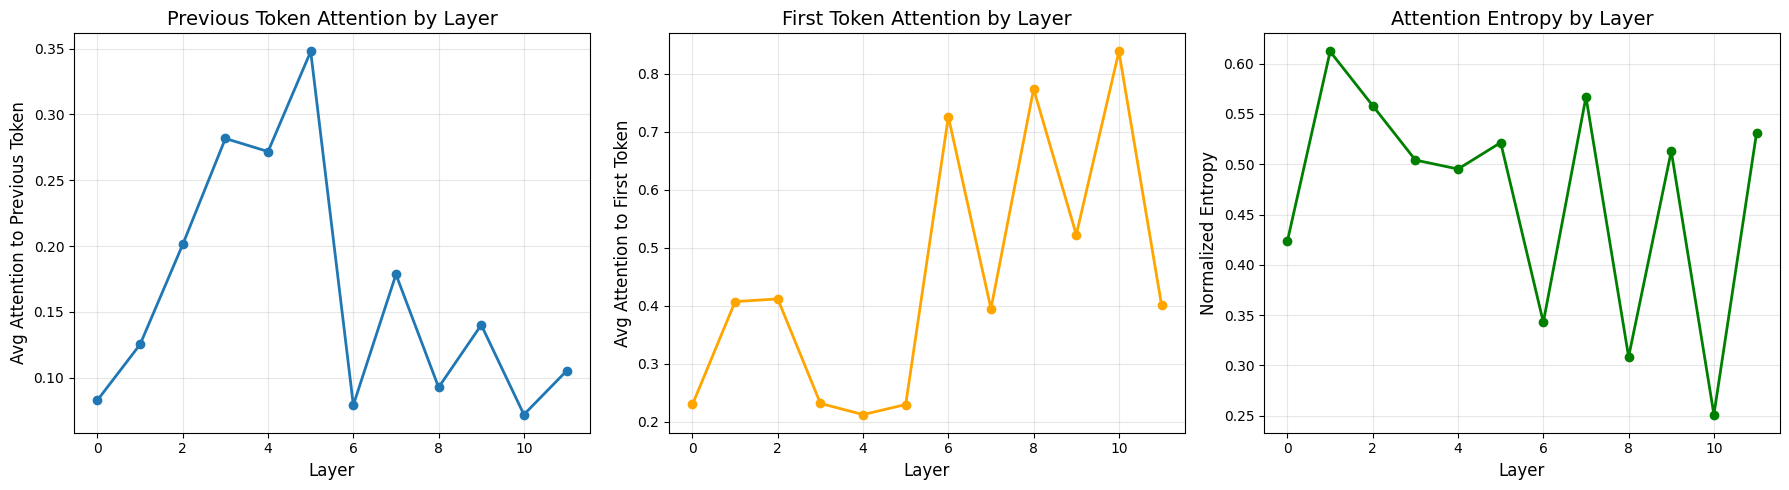

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Previous token attention
axes[0].plot(df_layers['layer'], df_layers['prev_token_attn'], marker='o', linewidth=2)
axes[0].set_xlabel('Layer', fontsize=12)
axes[0].set_ylabel('Avg Attention to Previous Token', fontsize=12)
axes[0].set_title('Previous Token Attention by Layer', fontsize=14)
axes[0].grid(True, alpha=0.3)
# First token attention
axes[1].plot(df_layers['layer'], df_layers['first_token_attn'], marker='o', linewidth=2, color='orange')
axes[1].set_xlabel('Layer', fontsize=12)
axes[1].set_ylabel('Avg Attention to First Token', fontsize=12)
axes[1].set_title('First Token Attention by Layer', fontsize=14)
axes[1].grid(True, alpha=0.3)
# Entropy
axes[2].plot(df_layers['layer'], df_layers['normalized_entropy'], marker='o', linewidth=2, color='green')
axes[2].set_xlabel('Layer', fontsize=12)
axes[2].set_ylabel('Normalized Entropy', fontsize=12)
axes[2].set_title('Attention Entropy by Layer', fontsize=14)
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Previous token attention peaks at Layer 5 (0.35), first-token attention dominates in Layers 6-10 (peaks at 0.84 in Layer 10), and entropy drops dramatically in Layer 11 (0.25) showing focused attention together revealing the network's computational strategy: **build local patterns in middle layers, aggregate globally in later layers, then focus sharply for final prediction.**

In [19]:
print("\n1. HEAD SPECIALIZATION:")
print(f"   - {len(df_heads[df_heads['prev_token_score'] > 0.7])} heads show strong previous token attention (>0.7)")
print(f"   - {len(df_heads[df_heads['first_token_score'] > 0.5])} heads show strong first token attention (>0.5)")
print(f"   - {len(df_heads[df_heads['is_focused']])} heads are highly focused (entropy < 0.3)")
print(f"   - {len(df_heads[df_heads['is_broad']])} heads show broad attention (entropy > 0.7)")
print("\n2. LAYER-WISE PATTERNS:")
early_layers = df_layers[df_layers['layer'] < 4]
late_layers = df_layers[df_layers['layer'] >= 8]
print(f"   - Early layers (0-3) avg entropy: {early_layers['normalized_entropy'].mean():.3f}")
print(f"   - Late layers (8-11) avg entropy: {late_layers['normalized_entropy'].mean():.3f}")
print(f"   - Early layers prev token attn: {early_layers['prev_token_attn'].mean():.3f}")
print(f"   - Late layers prev token attn: {late_layers['prev_token_attn'].mean():.3f}")
print("\n3. ATTENTION DIVERSITY:")
print(f"   - Entropy range: {df_heads['normalized_entropy'].min():.3f} to {df_heads['normalized_entropy'].max():.3f}")
print(f"   - Average entropy across all heads: {df_heads['normalized_entropy'].mean():.3f}")
print(f"   - Std dev of entropy: {df_heads['normalized_entropy'].std():.3f}")


1. HEAD SPECIALIZATION:
   - 3 heads show strong previous token attention (>0.7)
   - 56 heads show strong first token attention (>0.5)
   - 51 heads are highly focused (entropy < 0.3)
   - 0 heads show broad attention (entropy > 0.7)

2. LAYER-WISE PATTERNS:
   - Early layers (0-3) avg entropy: 0.525
   - Late layers (8-11) avg entropy: 0.401
   - Early layers prev token attn: 0.173
   - Late layers prev token attn: 0.103

3. ATTENTION DIVERSITY:
   - Entropy range: 0.001 to 0.675
   - Average entropy across all heads: 0.346
   - Std dev of entropy: 0.166


**Conclusion**

GPT-Neo-125M exhibits strong attention specialization, with early layers exploring broad context and later layers consolidating information through focused, low-entropy heads rather than sequential token tracking.